In [1]:
# import package
import deepsim_analyzer as da
import numpy as np
import matplotlib.pyplot as plt
import cv2

dataset_path = "../data/processed/test_dataset.h5"
image_folder = "../data/raw/"

# read images
# we need to pass PIL images to the get_features function of visualize attention
img_array0 = da.io.load_image("../data/raw_immutable/adriaen-brouwer_the-bitter-drunk.jpg", return_np=False)
img_array1 = da.io.load_image("../data/raw_immutable/Branches_with_Almond_Blossom.png", return_np=False)
img_array2 = da.io.load_image("../data/raw_immutable/nighthawks.png", return_np=False)

# calculate hash
hash_1 = da.io.get_image_hash(np.array(img_array1))
hash_2 = da.io.get_image_hash(np.array(img_array2))

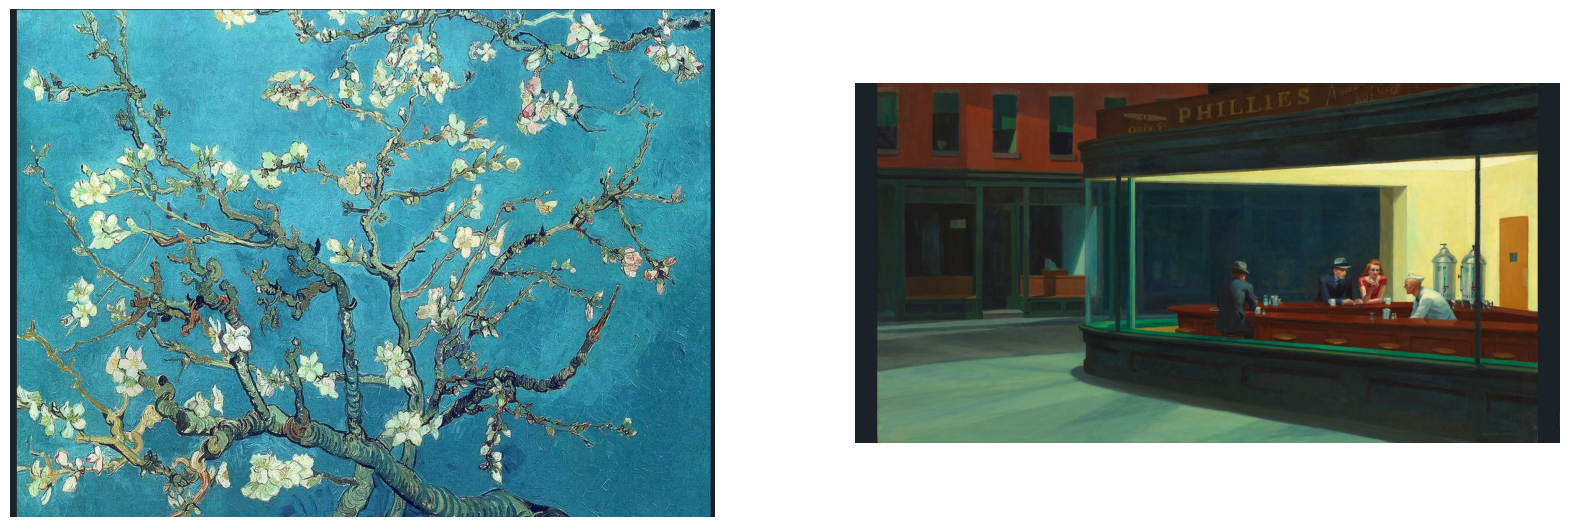

In [2]:
# pick two test images
test_image = img_array1
test_image2 = img_array2

f, axarr = plt.subplots(1,2, figsize=(20,10))
axarr[0].imshow(test_image)
axarr[0].axis('off')
axarr[1].imshow(test_image2)
axarr[1].axis('off')
plt.show()

In [3]:
# get feature vectors and feature maps

feature_vector1, feature_maps1 = da.similarity_methods.dino.get_features(test_image, return_feature_maps=True, resize=True)
feature_vector2, feature_maps2 = da.similarity_methods.dino.get_features(test_image2, return_feature_maps=True, resize=True)

Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])
Pretrained weights found at /home/parting/master_AI/MMA/deepsim-analyzer/data/raw_immutable/models/dino_vitbase8_pretrain_full_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight'])


(-0.5, 1677.5, 857.5, -0.5)

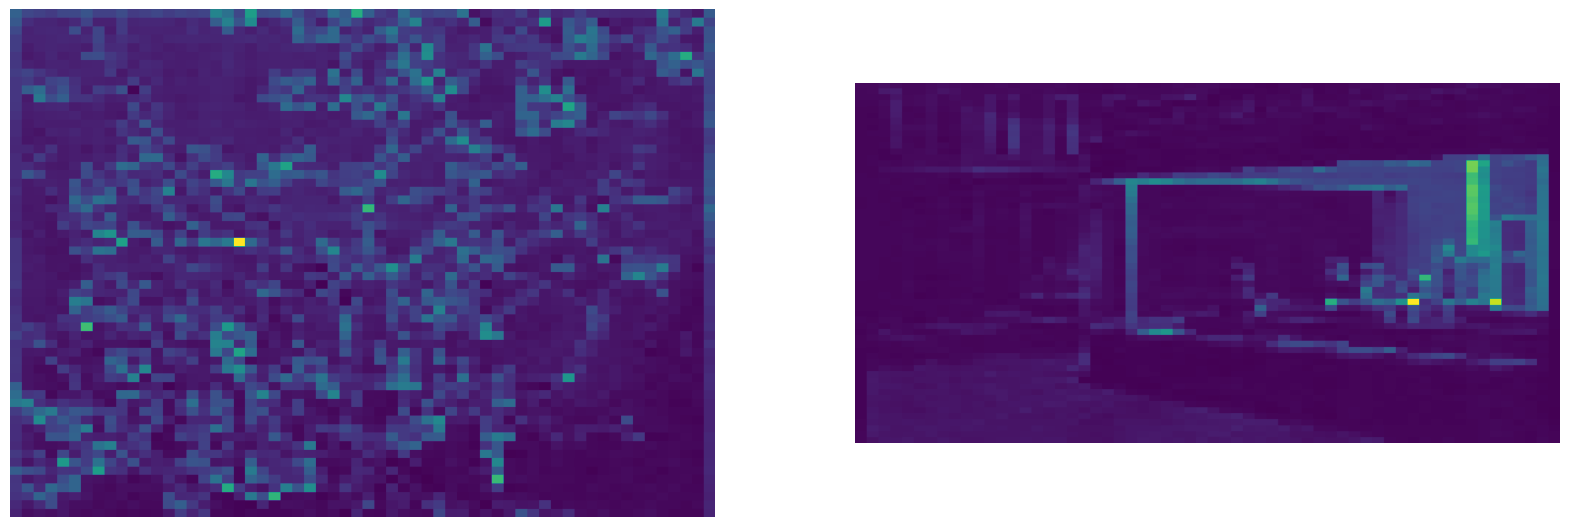

In [4]:
test_head = feature_maps1[2][4]
test_head2 = feature_maps2[2][4]
f, axarr = plt.subplots(1,2, figsize=(20,10))
axarr[0].imshow(test_head)
axarr[0].axis('off')
axarr[1].imshow(test_head2)
axarr[1].axis('off')

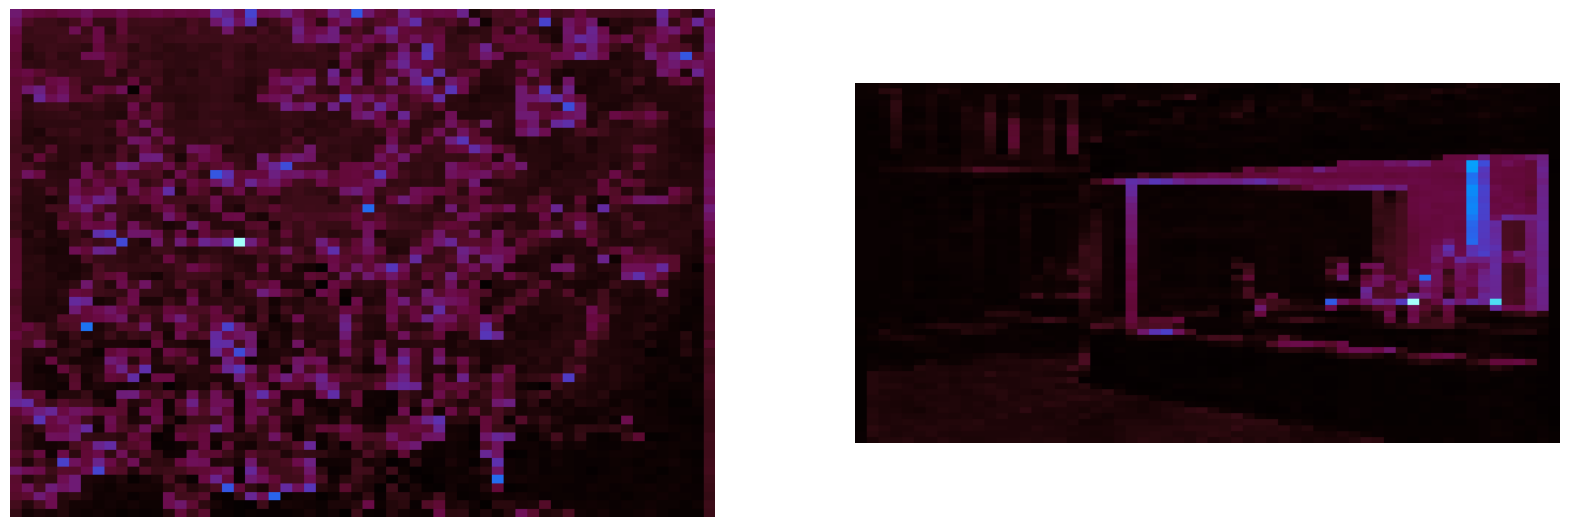

In [5]:
def feature_map_to_colormap(test_head):
    minmaxed = (test_head - test_head.min()) / (test_head.max() - test_head.min())
    minmaxed *= 255
    minmaxed = minmaxed.astype(np.uint8)
    heatmap = cv2.applyColorMap(minmaxed, cv2.COLORMAP_INFERNO)
    return heatmap, minmaxed

heatmap_1, minmaxed_1 = feature_map_to_colormap(test_head)
heatmap_2, minmaxed_2 = feature_map_to_colormap(test_head2)

f, axarr = plt.subplots(1,2, figsize=(20,10))
axarr[0].imshow(heatmap_1)
axarr[0].axis('off')
axarr[1].imshow(heatmap_2)
axarr[1].axis('off')
plt.show()

In [6]:

def overlay_transparent(background, overlay, x, y):
    # taken from https://stackoverflow.com/questions/40895785/using-opencv-to-overlay-transparent-image-onto-another-image

    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        return background

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        overlay = np.concatenate(
            [
                overlay,
                np.ones((overlay.shape[0], overlay.shape[1], 1), dtype = overlay.dtype) * 255
            ],
            axis = 2,
        )

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:] / 255.0

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image

    return background

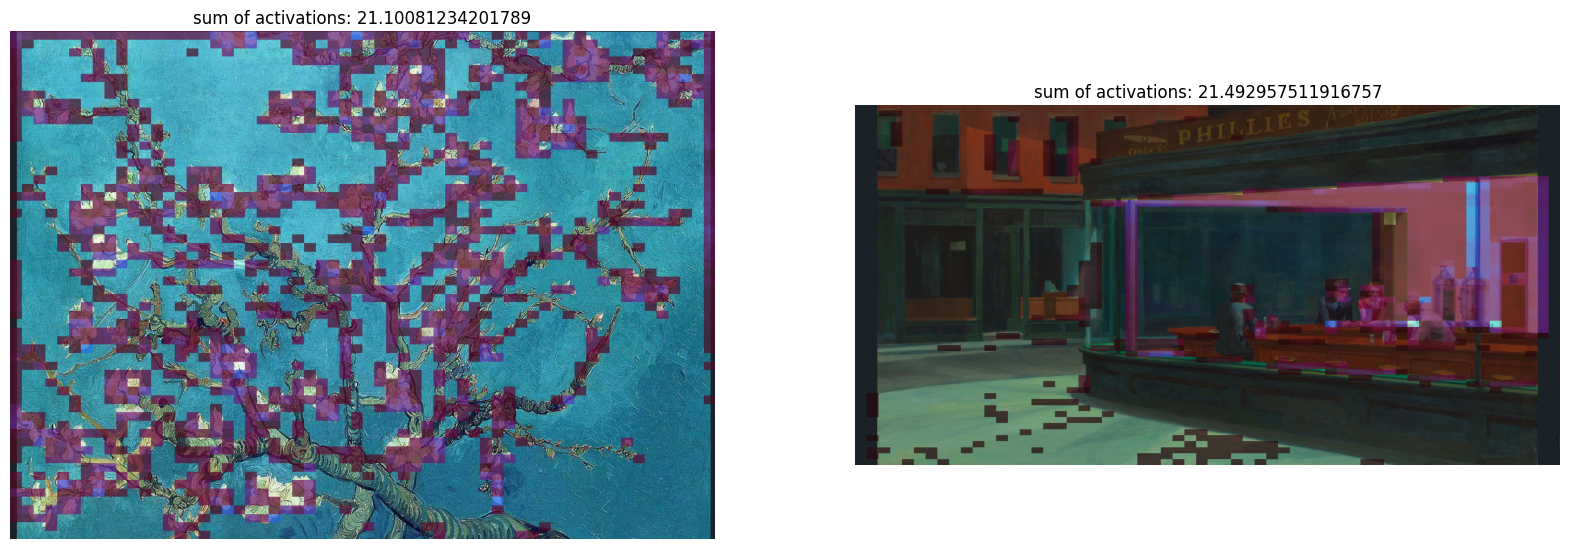

In [10]:
# overlay heatmap on original image for better visibility

def overlay_heatmap(original_image, heatmap, minmaxed, transparancy=0.7):

    # add empty alpha channel
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_RGB2RGBA)

    # only take top 50% of probability mass
    mask = np.zeros_like(minmaxed, dtype=np.float32)
    mask[minmaxed >= np.mean(minmaxed)] = 1
    mask *= 255

    # make overlay transparant
    mask[mask == 255] *= transparancy
    mask = mask.astype(np.uint8)

    # add alpha channel to heatmap image
    heatmap[:,:, 3] = mask

    # mix heatmap with original image
    overlayed = overlay_transparent(np.array(original_image), heatmap, 0, 0)
    return overlayed

overlayed_1 = overlay_heatmap(test_image, heatmap_1, minmaxed_1)
overlayed_2 = overlay_heatmap(test_image2, heatmap_2, minmaxed_2)

f, axarr = plt.subplots(1,2, figsize=(20,10))
axarr[0].imshow(overlayed_1)
axarr[0].axis('off')
axarr[0].set_title(f"sum of activations: {np.sum(feature_vector1)}")
axarr[1].imshow(overlayed_2)
axarr[1].axis('off')
axarr[1].set_title(f"sum of activations: {np.sum(feature_vector2)}")
plt.show()

In [9]:
from scipy import spatial

distance = spatial.distance.cosine(feature_vector1, feature_vector2)
print(f"cosine distance: {distance}")

cosine distance: 0.018119793221142433
